# 주제 : <br>오디오 데이터에서 머신러닝 모델을 활용한 화자 분리
----------

## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 모두 코드로 작성되어 있습니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.

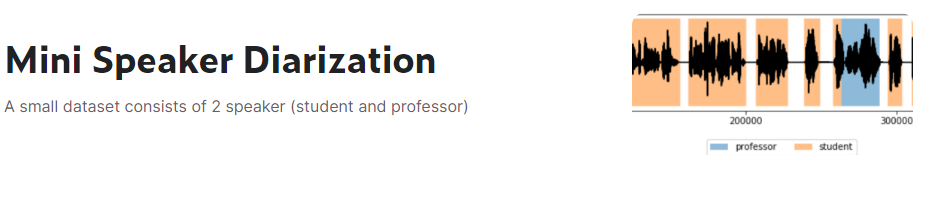

- 데이터 출처: https://www.kaggle.com/datasets/wiradkp/mini-speech-diarization

    
## 데이터 소개
    - 데이터는 Youtube의 MagooshTOEFL의 TOEFL Listening practice에서 가져왔습니다.
    - Audacity라는 소리 편집기로 훈련, 검증 및 테스트 세트로 편집.
    - 이 데이터세트에는 학생과 교수 2명의 화자가 있습니다

    
    - 데이터를 4개의 폴더로 구성:
    raw: 원본 mp3 오디오를 포함
    train: 각 화자에 대한 train dataset 샘플(wav)
    valid: 각 화자에 대한 validation dataset 샘플(wav)
    test: 각 화자에 대한 test dataset 샘플(wav)

    
## 최종 목표
    - Scikit-learn 기반의 분류 모델 학습 방법 습득
    - 음성 데이터 labeling 방법 습득
    - 학습된 모델의 평가 방법 및 시각화 방법 습득
---

## Colab Notebook에 Kaggle API 세팅하기 및 Dataset 다운로드


In [ ]:
import os
import numpy as np
import pandas as pd
import glob
import librosa
import librosa.display
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# os.environ을 이용하여 Kaggle API Username, Key 세팅하기
os.environ['KAGGLE_USERNAME'] = 'ohaeyoon'
os.environ['KAGGLE_KEY'] = '10dc24310cfb170d3a1d5df5c6931dd4'

In [ ]:
!kaggle datasets download -d wiradkp/mini-speech-diarization
!unzip '*.zip'

mini-speech-diarization.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  mini-speech-diarization.zip
replace dataset/raw/TOEFL Listening Practice Test.mp3? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## 파일 경로 및 오디오 클래스 가져오기

In [ ]:
for dirname, _, filenames in os.walk('/content/dataset'):
  for filename in filenames :
    print(os.path.join(dirname, filename))

/content/dataset/test/test.wav
/content/dataset/train/student/audio_6.wav
/content/dataset/train/student/audio_2.wav
/content/dataset/train/student/audio_5.wav
/content/dataset/train/student/audio_4.wav
/content/dataset/train/student/audio_1.wav
/content/dataset/train/student/audio_3.wav
/content/dataset/train/professor/audio_6.wav
/content/dataset/train/professor/audio_7.wav
/content/dataset/train/professor/audio_2.wav
/content/dataset/train/professor/audio_5.wav
/content/dataset/train/professor/audio_4.wav
/content/dataset/train/professor/audio_1.wav
/content/dataset/train/professor/audio_3.wav
/content/dataset/raw/TOEFL Listening Practice Test.mp3
/content/dataset/raw/reference.txt
/content/dataset/valid/student/audio_7.wav
/content/dataset/valid/student/audio_8.wav
/content/dataset/valid/professor/audio_9.wav
/content/dataset/valid/professor/audio_8.wav


In [ ]:
def read_path_audio_and_target(is_train = True):
  paths, targets = [], []
  if is_train:
    name = 'train'
  else :
    name = 'valid'

  for cls in ['student', 'professor']:
    path = glob.glob(f'/content/dataset/{name}/{cls}/*')

    if cls == 'student':
      target = [0 for _ in range(len(path))]
    else :
      target = [1 for _ in range(len(path))]

    paths.extend(path)
    targets.extend(target)

  return paths, targets

In [ ]:
paths_train, targets_train = read_path_audio_and_target(is_train = True)
paths_test, targets_test = read_path_audio_and_target(is_train = False)

In [ ]:
print(paths_test)
print(targets_test)

['/content/dataset/valid/student/audio_7.wav', '/content/dataset/valid/student/audio_8.wav', '/content/dataset/valid/professor/audio_9.wav', '/content/dataset/valid/professor/audio_8.wav']
[0, 0, 1, 1]


In [ ]:
print(paths_train[0])
sample_student, sr = librosa.load(paths_train[0])
display(Audio(sample_student, rate = sr))

/content/dataset/train/student/audio_6.wav


In [ ]:
print(paths_train[-1])
sample_student, sr = librosa.load(paths_train[-1])
display(Audio(sample_student, rate = sr))

/content/dataset/train/professor/audio_3.wav


In [ ]:
audio, sr = librosa.load(paths_train[-1])
audio.shape

(405616,)

## 오디오 및 클래스 모양 변경

In [ ]:
def reshape_sound_and_target(path_sound, targets, segment_size_t = 1):
  segments_sound, segments_target = [], []

  for i in range(len(path_sound)):
    y, sr = librosa.load(path_sound[i])
    signal_len = len(y)
    segment_size = int(segment_size_t * sr)
    segments = [y[x:x + segment_size] for x in np.arange(0, signal_len, segment_size)]

    target = [targets[i] for _ in range(len(segments))]

    segments_sound.extend(segments)
    segments_target.extend(target)

  segments_sound = np.array(segments_sound)
  segments_target = np.array(segments_target)

  return segments_sound, segments_target, sr

In [ ]:
len(paths_train)

13

In [ ]:
segment_size_t = 0.5

segments_sound_train, segments_target_train, sr = reshape_sound_and_target(paths_train, targets_train, segment_size_t)
segments_sound_test, segments_target_test, sr = reshape_sound_and_target(paths_test, targets_test, segment_size_t)

In [ ]:
print(f'segments_sound_train : {segments_sound_train.shape}')
print(f'segments_target_train : {segments_target_train.shape}')
print(f'sampling rate :{sr}')

segments_sound_train : (241,)
segments_target_train : (241,)
sampling rate :22050


In [ ]:
display(Audio(segments_sound_train[0], rate = sr))

In [ ]:
segments_target_train[0]

0

In [ ]:
display(Audio(segments_sound_train[-1], rate = sr))

In [ ]:
segments_target_train[-1]

1

## Create Feature

In [ ]:
def create_features(segments, sr):
  features = [
              ('chroma_stft', librosa.feature.chroma_stft), #크로마벡터는 서양음악의 12 음계로 화성적 특징을 나타낸것으로, 특정 시간에 존재하는 각 반음들의 에너지 정보를 12차원의 벡터값으로 표현
              ('rms', librosa.feature.rms), #rms는 root mean square로  waveform의 waves를 구함
              ('spectral_centroid', librosa.feature.spectral_centroid),  #wave각 프레임마다 평균 주파수 반환
              ('spectral_bandwidth', librosa.feature.spectral_bandwidth), #스펙트럼 대역폭을 계산
              ('spcetral_rollof', librosa.feature.spectral_rolloff), #총 스펙트럼 에너지의 특정 백분율 이하의 주파수
              ('zero_crossing_rate', librosa.feature.zero_crossing_rate), #말 그대로 신호가 0을 지나는, 즉 신호의 부호가 바뀌는 비율
              ('mfcc', librosa.feature.mfcc) #오디오 신호에서 추출할 수 있는 feature로, 소리의 고유한 특징을 나타내는 수치
  ]

  features_segmentation = []
  for seg in segments:
    feature_segmentation = []
    try :
      for name, func in features:
        if name in['zero_crossing_rate','rms']:
          y0 = func(y=seg)
          feature_segmentation.append(np.mean(y0))

        elif name == 'mfcc' :
          y0 = func(y=seg, sr=sr)
          for i, m in enumerate(y0, 1):
            feature_segmentation.append(np.mean(m))

        else :
          y0 = func(y=seg, sr=sr)
          feature_segmentation.append(np.mean(y0))
    except Exception as e:
      print(e)
    
    features_segmentation.append(feature_segmentation)
  
  features_segmentation = np.array(features_segmentation)
  return features_segmentation

In [ ]:
feature_train = create_features(segments_sound_train, sr)
feature_test = create_features(segments_sound_test, sr)

print(f'feature_train : {feature_train.shape}')
print(f'feature_test : {feature_test.shape}')

feature_train : (241, 26)
feature_test : (61, 26)


In [ ]:
feature_train[0]

array([ 3.00993562e-01,  8.02926570e-02,  1.98289989e+03,  2.05665154e+03,
        3.59555553e+03,  8.19424716e-02, -2.57217133e+02,  8.51826706e+01,
       -2.09173527e+01,  2.33730907e+01, -1.47115812e+01, -6.65160227e+00,
        1.39875484e+00,  2.08819509e+00, -1.08063545e+01,  1.54503880e+01,
       -1.53989954e+01,  1.05346940e-01, -1.10821619e+01, -1.66164434e+00,
       -1.78009287e-01, -9.43575191e+00, -8.59159470e-01, -8.53563595e+00,
       -8.53853607e+00, -3.13671279e+00])

## StandardScaler

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(feature_train)

StandardScaler()

In [ ]:
feature_train_scaler = scaler.transform(feature_train)
feature_test_scaler = scaler.transform(feature_test)

feature_train.shape, feature_test_scaler.shape

((241, 26), (61, 26))

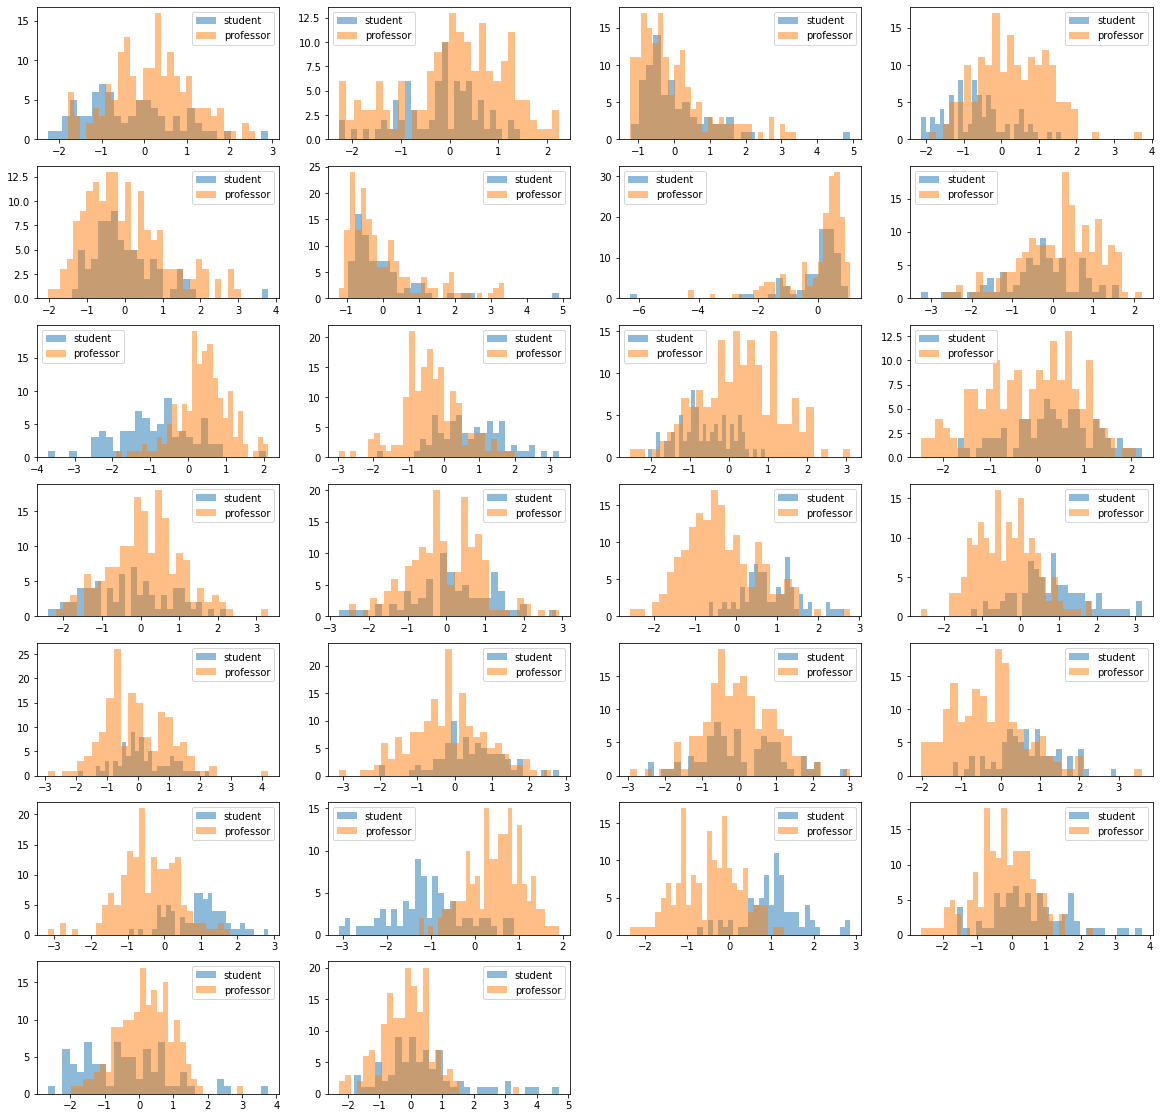

In [ ]:
plt.figure(figsize=(20,20))
for i in range(0, feature_train_scaler.shape[1]):
  plt.subplot(7, 4, i+1)
  plt.hist(feature_train_scaler[:,i][segments_target_train == 0], bins = 30, alpha= 0.5)
  plt.hist(feature_train_scaler[:,i][segments_target_train == 1], bins = 30, alpha= 0.5)
  plt.legend(['student','professor'])

## 학습 및 평가

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

### SVC

In [ ]:
model_svc = SVC(C = 0.1)
model_svc.fit(feature_train_scaler, segments_target_train)

SVC(C=0.1)

### SVC 평가

In [ ]:
from sklearn.metrics import classification_report
pred = model_svc.predict(feature_test_scaler)
print(classification_report(segments_target_test, pred, target_names=['student','professor']))

              precision    recall  f1-score   support

     student       1.00      0.89      0.94        19
   professor       0.95      1.00      0.98        42

    accuracy                           0.97        61
   macro avg       0.98      0.95      0.96        61
weighted avg       0.97      0.97      0.97        61



### RandomForestClassifier

In [ ]:
model_rfc = RandomForestClassifier(random_state = 13)
model_rfc.fit(feature_train_scaler, segments_target_train)

RandomForestClassifier(random_state=13)

### RandomForestClassifier 평가

In [ ]:
pred = model_rfc.predict(feature_test_scaler)
print(classification_report(segments_target_test, pred, target_names=['student','professor']))

              precision    recall  f1-score   support

     student       1.00      0.95      0.97        19
   professor       0.98      1.00      0.99        42

    accuracy                           0.98        61
   macro avg       0.99      0.97      0.98        61
weighted avg       0.98      0.98      0.98        61



## Model Test 

In [ ]:
def read_and_reshape_sound(path, segment_size_t=0.5):
  sound, sr = librosa.load(path)

  signal_len = len(sound)
  segment_size = int(segment_size_t * sr)

  segments = np.array([sound[x:x + segment_size] for x in np.arange(0, signal_len, segment_size)])
  return segments, sr

In [ ]:
path = '/content/dataset/test/test.wav'
segment_size_t = 0.5
segments, sr = read_and_reshape_sound(path, segment_size_t)

display(Audio(np.concatenate(segments), rate = sr))

In [ ]:
feature_valid = create_features(segments, sr)
feature_valid_scaler = scaler.transform(feature_valid)
feature_valid_scaler.shape

(55, 26)

In [ ]:
pred1 = model_rfc.predict(feature_valid_scaler)
pred1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [ ]:
pred2 = model_svc.predict(feature_valid_scaler)
pred2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])